Mixed effects model

In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import jax

In [4]:

n_schools = 50
n_students_per_school = 50

true_mu = 0
true_tau = 1
true_sigma = 1
true_theta = 0.5
true_school_treatment = 0.5
true_student_treatment = 0.5
true_school_notation = 0.5

# Define transition functions
transition_funcs = {
    '_b': lambda a: a,
    'c': lambda a, b: a**3 + (b+1)**2,
    '_d': lambda b, c: b+1 - c,
    'e': lambda c, d: c + d+1
}

# Generate school effects (a)
school_effects = np.random.normal(0, true_tau, size=(n_schools, 1))

# Generate student scores (b)
student_scores = true_mu + school_effects + np.random.normal(0, true_sigma, (n_schools, n_students_per_school))

# Generate school treatment (c)
school_treatment = np.array([transition_funcs['c'](a, np.mean(b)) for a, b in zip(school_effects, student_scores)])+np.random.normal(0,1,size=(n_schools,1))

# Generate student treatment (d)
student_treatment = np.array([transition_funcs['_d'](b, c) for b, c in zip(student_scores, school_treatment)])+np.random.normal(0,1,size=(n_schools,n_students_per_school))

# Calculate school notation (e)
school_notation = np.array([transition_funcs['e'](c, np.mean(d)) for c, d in zip(school_treatment, student_treatment)])

# Create a DataFrame
data = pd.DataFrame({
    'school': np.repeat(range(n_schools), n_students_per_school),
    'score': student_scores.flatten(),
    'school_effects': np.repeat(school_effects, n_students_per_school),
    'school_treatment': np.repeat(school_treatment, n_students_per_school),
    'student_treatment': student_treatment.flatten(),
    'school_notation': np.repeat(school_notation, n_students_per_school)
})


In [5]:

# Import necessary libraries for mixed effects model
from statsmodels.formula.api import mixedlm # type: ignore
import statsmodels.api as sm # type: ignore


In [6]:
# Prepare the data for fixed effects model
data['school'] = data['school'].astype('category')

# Define the fixed effects model
# We'll use student characteristics (score) as the main focus,
# and include school_treatment, student_treatment, and school_notation
fixed_model = sm.OLS.from_formula("score ~ C(school) + student_treatment + school_treatment + school_notation", data=data)

# Fit the model
fixed_model_fit = fixed_model.fit()

# Print the summary of the model
print(fixed_model_fit.summary())

# Extract coefficients
coefficients = fixed_model_fit.params

# Print key model results
print("\nKey Model Results:")
print(f"Number of Observations: {fixed_model_fit.nobs}")
print(f"R-squared: {fixed_model_fit.rsquared:.4f}")
print(f"Adjusted R-squared: {fixed_model_fit.rsquared_adj:.4f}")
print(f"F-statistic: {fixed_model_fit.fvalue:.4f}")
print(f"Prob (F-statistic): {fixed_model_fit.f_pvalue:.4f}")

print("\nFixed Effects (selected):")
print(f"Intercept: {coefficients['Intercept']:.3f}")
print(f"Student Treatment: {coefficients['student_treatment']:.3f}")
print(f"School Treatment: {coefficients['school_treatment']:.3f}")
print(f"School Notation: {coefficients['school_notation']:.3f}")

# Print the first few school effects
print("\nSchool Effects (first 5):")
school_effects = [coef for name, coef in coefficients.items() if name.startswith('C(school)')]
for i, effect in enumerate(school_effects[:5], 1):
    print(f"School {i}: {effect:.3f}")

print("\nNote: This model treats schools as fixed effects. It focuses on student characteristics")
print("while also considering treatment and notation effects. However, it doesn't account for")
print("the hierarchical structure of the data like a mixed effects model would.")


                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     171.5
Date:                Wed, 11 Sep 2024   Prob (F-statistic):               0.00
Time:                        15:29:17   Log-Likelihood:                -2619.8
No. Observations:                2500   AIC:                             5342.
Df Residuals:                    2449   BIC:                             5639.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.0614      0.11

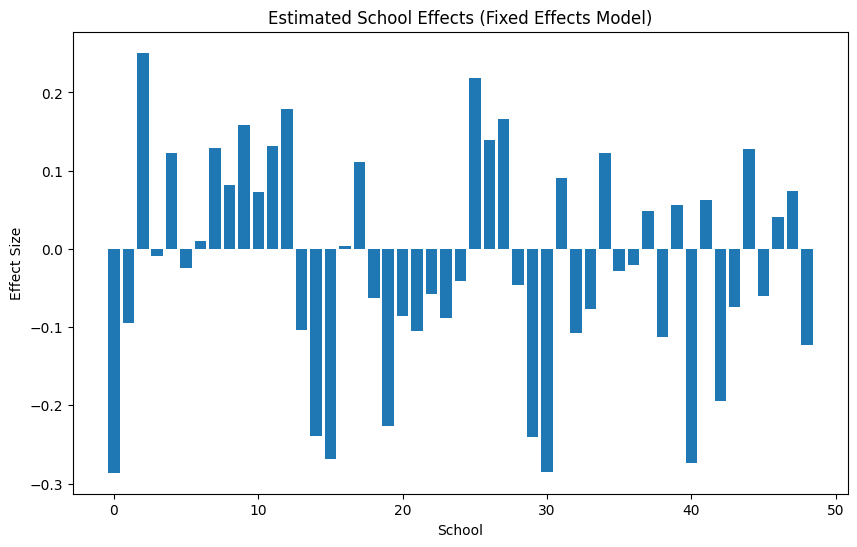

Fixed Effects Model Performance:
Mean squared error: 0.48
R-squared score: 0.78


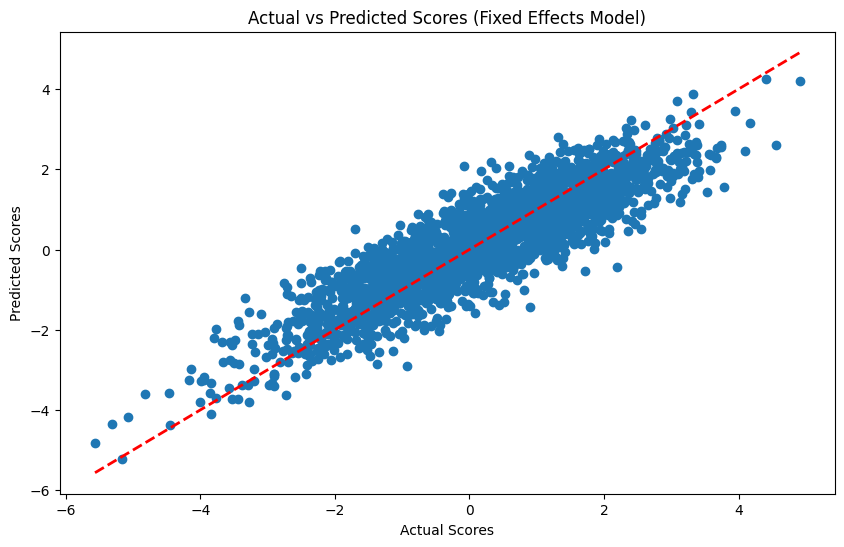

In [7]:
# Import necessary metrics
from sklearn.metrics import mean_squared_error, r2_score

# Plot school effects for fixed effects model
plt.figure(figsize=(10, 6))
plt.bar(range(len(school_effects)), school_effects)
plt.title('Estimated School Effects (Fixed Effects Model)')
plt.xlabel('School')
plt.ylabel('Effect Size')
plt.show()

# Make predictions using fixed effects model
y_pred_fixed = fixed_model_fit.predict(data)

# Calculate and print model performance metrics for fixed effects model
mse_fixed = mean_squared_error(data['score'], y_pred_fixed)
r2_fixed = r2_score(data['score'], y_pred_fixed)

print("Fixed Effects Model Performance:")
print(f"Mean squared error: {mse_fixed:.2f}")
print(f"R-squared score: {r2_fixed:.2f}")

# Plot actual vs predicted scores for fixed effects model
plt.figure(figsize=(10, 6))
plt.scatter(data['score'], y_pred_fixed)
plt.plot([data['score'].min(), data['score'].max()], [data['score'].min(), data['score'].max()], 'r--', lw=2)
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores (Fixed Effects Model)')
plt.show()

# If mixed effects model is available, compare with fixed effects model
if 'mixed_model_fit' in locals():
    # Make predictions using mixed effects model
    y_pred_mixed = mixed_model_fit.predict(data)

    # Calculate and print model performance metrics for mixed effects model
    mse_mixed = mean_squared_error(data['score'], y_pred_mixed)
    r2_mixed = r2_score(data['score'], y_pred_mixed)

    print("\nMixed Effects Model Performance:")
    print(f"Mean squared error: {mse_mixed:.2f}")
    print(f"R-squared score: {r2_mixed:.2f}")

    # Plot actual vs predicted scores for mixed effects model
    plt.figure(figsize=(10, 6))
    plt.scatter(data['score'], y_pred_mixed)
    plt.plot([data['score'].min(), data['score'].max()], [data['score'].min(), data['score'].max()], 'r--', lw=2)
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.title('Actual vs Predicted Scores (Mixed Effects Model)')
    plt.show()

    # Compare fixed and mixed effects models
    print("\nModel Comparison:")
    print(f"Fixed Effects MSE: {mse_fixed:.2f}, R-squared: {r2_fixed:.2f}")
    print(f"Mixed Effects MSE: {mse_mixed:.2f}, R-squared: {r2_mixed:.2f}")

In [15]:
# Generate new data based on the fitted Random Forest model

# Create a new dataset with the same structure as the original
new_data = pd.DataFrame(columns=X.columns)

# Generate random values for each school
for school in range(n_schools):
    school_data = pd.DataFrame(0, index=range(n_students_per_school), columns=X.columns)
    school_data[f'school_{school}'] = 1
    new_data = pd.concat([new_data, school_data], ignore_index=True)

# Use the trained model to predict scores for the new data
new_scores = rf_model.predict(new_data)

# Add the predicted scores to the new dataset
new_data['predicted_score'] = new_scores

# Display summary statistics of the generated data
print("Summary statistics of generated data:")
print(new_data['predicted_score'].describe())

# Plot the distribution of generated scores
plt.figure(figsize=(10, 6))
plt.hist(new_data['predicted_score'], bins=30, edgecolor='black')
plt.title('Distribution of Generated Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

# Compare the distribution of original and generated scores
plt.figure(figsize=(10, 6))
plt.hist(data['score'], bins=30, alpha=0.5, label='Original Scores', edgecolor='black')
plt.hist(new_data['predicted_score'], bins=30, alpha=0.5, label='Generated Scores', edgecolor='black')
plt.title('Comparison of Original and Generated Score Distributions')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


NameError: name 'X' is not defined

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np



In [23]:
# Train a classifier to distinguish between original and generated data

# Combine original and generated data
original_data = data.copy()
original_data['is_original'] = 1
generated_data = new_data.copy()
generated_data['is_original'] = 0

combined_data = pd.concat([original_data, generated_data], ignore_index=True)

# Prepare features and target
X_combined = combined_data.drop(['score', 'predicted_score', 'is_original'], axis=1)
y_combined = combined_data['is_original']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Create a pipeline with SimpleImputer and KNeighborsClassifier
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', KNeighborsClassifier())
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Generated', 'Original']))

# Note: KNeighborsClassifier doesn't have feature_importances_ attribute
# So we'll skip the feature importance plot

print("Note: Feature importance plot is not available for KNeighborsClassifier.")


Classifier accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

   Generated       1.00      1.00      1.00       500
    Original       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Note: Feature importance plot is not available for KNeighborsClassifier.


In [24]:
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline that first imputes missing values, then applies KNN
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # You can change 'mean' to 'median' or 'most_frequent' if needed
    ('classifier', KNeighborsClassifier())
])

# Define the parameter grid to search
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__p': [1, 2]  # Only relevant for Minkowski metric
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Use all available cores
)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score:.4f}")

# Use the best model for predictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy with best model: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Generated', 'Original']))

Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'uniform'}
Best cross-validation score: 1.0000
Test accuracy with best model: 1.0000

Classification Report:
              precision    recall  f1-score   support

   Generated       1.00      1.00      1.00       500
    Original       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



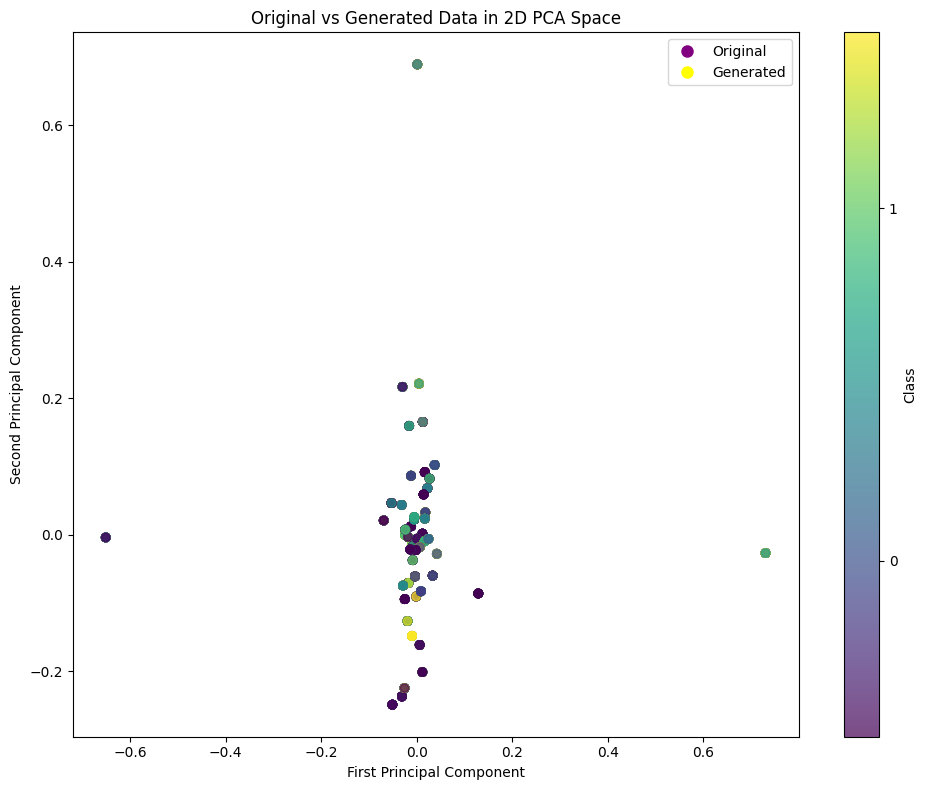

In [25]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)

# Add labels and title
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Original vs Generated Data in 2D PCA Space')

# Add a color bar
plt.colorbar(scatter, label='Class', ticks=[0, 1])
plt.clim(-0.5, 1.5)

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Original', 
                              markerfacecolor='purple', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='Generated', 
                              markerfacecolor='yellow', markersize=10)]
plt.legend(handles=legend_elements, loc='best')

# Show the plot
plt.tight_layout()
plt.show()
